Load Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sentiment_df = pd.read_csv('fear_greed_index.csv')
historical_df = pd.read_csv('historical_data.csv')

#lower case
sentiment_df.columns = sentiment_df.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Step 2: Convert to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], format='%d-%m-%Y %H:%M')


In [ ]:
sentiment_df.shape
historical_df.shape

sentiment_df.info()
historical_df.info()

sentiment_df.isnull().sum()
historical_df.isnull().sum()

historical_df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       2644 non-null   int64         
 1   value           2644 non-null   int64         
 2   classification  2644 non-null   object        
 3   date            2644 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           211224 non-null  object        
 1   Coin              211224 non-null  object        
 2   Execution Price   211224 non-null  float64       
 3   Size Tokens       211224 non-null  float64       
 4   Size USD          211224 non-null  float64       
 5   Side       

np.int64(0)

**Sentiment_df:**

Number of rows:2644

Number of columns:4

Missing values:0

Duplicates:0

**Historical Data:**

Number of rows:211224

Number of columns:16

Missing values:0

Duplicates:0

In [ ]:
#lower case
historical_df.columns = historical_df.columns.str.strip().str.lower().str.replace(" ", "_")
historical_df['timestamp_ist'] = pd.to_datetime(historical_df['timestamp_ist']).dt.normalize()

daily_pnl = historical_df.groupby(['account','timestamp_ist'])['closed_pnl'].sum().reset_index()
# print(daily_pnl)

#Average Win rate
historical_df['win'] = historical_df['closed_pnl'] > 0
win_rate = historical_df.groupby(['account','timestamp_ist'])['win'].mean().reset_index()
mean_win_rate = win_rate['win'].mean()
print("Average Win Rate:",mean_win_rate)

# Number of TRades per day
trade_count = historical_df.groupby(['account','timestamp_ist']).size().reset_index(name='num_trades')
mean_trade_count = trade_count['num_trades'].mean()
print("Average Number of Trades per Day:",mean_trade_count)

Average Win Rate: 0.35992629782262336
Average Number of Trades per Day: 90.22810764630499


NO Leverage Data Was Given.

Average Win Rate : 0.3324113855516169

Average Number of Trades per Day: 7.04009599040096

In [ ]:
#Long / Short Ratio
historical_df['side'].unique()

long_short = historical_df.groupby(['account','timestamp_ist','side']).size().unstack(fill_value=0)

long_short['long_short_ratio'] = long_short.get('BUY',0) / long_short.get('SELL',1)
print(long_short)

long_short = long_short.reset_index()

df = historical_df.merge(
    long_short[['account','timestamp_ist','long_short_ratio']],
    on=['account','timestamp_ist'],
    how='left'
)

side                                                      BUY  SELL  \
account                                    timestamp_ist              
0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11       0   177   
                                           2024-11-17       0    68   
                                           2024-11-18       0    40   
                                           2024-11-22      12     0   
                                           2024-11-26      12    15   
...                                                       ...   ...   
0xbee1707d6b44d4d52bfe19e41f8a828645437aab 2025-04-27      50    32   
                                           2025-04-28     164   266   
                                           2025-04-29     432   470   
                                           2025-04-30      50    25   
                                           2025-05-01      87    44   

side                                                      long_short_ratio  

In [ ]:
#Normalise and Merging df
sentiment_df.columns = sentiment_df.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment_df.columns

daily_pnl['timestamp_ist'] = pd.to_datetime(daily_pnl['timestamp_ist'])
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
# Create a 'date' column in daily_pnl from its 'timestamp_ist' column and normalize it to date only
daily_pnl['date'] = daily_pnl['timestamp_ist'].dt.normalize()

# Ensure sentiment_df['date'] is also normalized to date only for consistent merging
sentiment_df['date'] = sentiment_df['date'].dt.normalize()

df = daily_pnl.merge(
    sentiment_df[['date','classification']],
    on='date',
    how='left'
)

# Merge trade_count into df
df = df.merge(
    trade_count[['account','timestamp_ist','num_trades']],
    on=['account','timestamp_ist'],
    how='left'
)

# Merge long_short_ratio into df
# Ensure long_short['timestamp_ist'] is datetime64[ns] before merging
long_short['timestamp_ist'] = pd.to_datetime(long_short['timestamp_ist'])
df = df.merge(
    long_short[['account','timestamp_ist','long_short_ratio']],
    on=['account','timestamp_ist'],
    how='left'
)

# **ANALYSIS**

In [ ]:
df.groupby('classification')['closed_pnl'].mean()

,closed_pnl
classification,
Extreme Fear,4619.439053
Extreme Greed,5161.922644
Fear,5328.818161
Greed,3318.100730
Neutral,3438.618818


Average Profit/loss         
**Classification  : closed_pnl**

Extreme Fear:	4619.439053

Extreme Greed:	5161.922644

Fear:	5328.818161

Greed	: 3318.100730

Neutral:	3438.618818



In [ ]:
# Win Rate comparison
df['win'] = df['closed_pnl'] > 0
df.groupby('classification')['win'].mean()

# Risk Proxy
df.groupby('classification')['closed_pnl'].std()

,closed_pnl
classification,
Extreme Fear,29534.839183
Extreme Greed,27496.863832
Fear,31659.771538
Greed,30599.040173
Neutral,17447.863645


**Most Win rate based on Classification**

Fear:	31659.771538

Greed:	30599.040173

In [ ]:
# Frequent VS Infrequent Traders
median_freq = df['num_trades'].median()

df['freq_segment'] = df['num_trades'].apply(
    lambda x: 'Frequent' if x > median_freq else 'Infrequent'
)
df.groupby(['classification','freq_segment'])['closed_pnl'].mean()

classification  freq_segment
Extreme Fear    Frequent         6799.753651
                Infrequent        457.020275
Extreme Greed   Frequent         8437.437459
                Infrequent       1627.473851
Fear            Frequent        10311.492505
                Infrequent        913.034911
Greed           Frequent         5486.377107
                Infrequent       1401.949513
Neutral         Frequent         5759.162182
                Infrequent       1118.075454
Name: closed_pnl, dtype: float64

Frequent traders loss High in Fear, followed by Extreme Fear

# **VISUALIZATION**

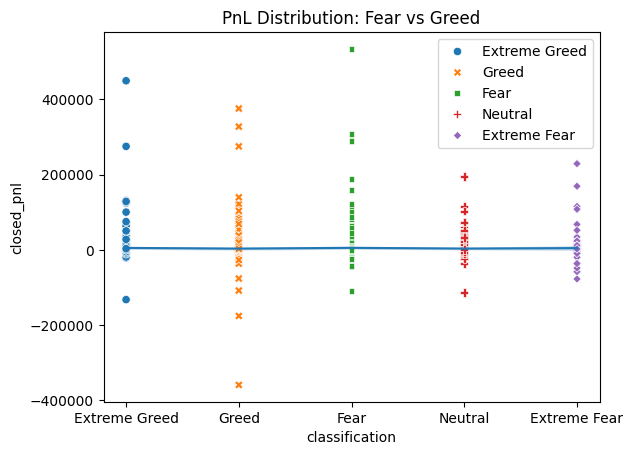

In [ ]:
sns.scatterplot(data=df, x='classification', y='closed_pnl', hue='classification', style="classification")
plt.title("PnL Distribution: Fear vs Greed")
sns.lineplot(data=df, x='classification', y='closed_pnl',)
plt.show()

/tmp/ipython-input-273/3361224637.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='classification', y='num_trades',palette="inferno")


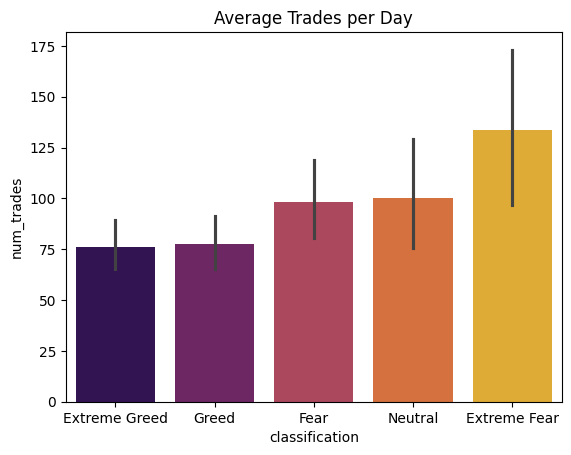

In [ ]:
df.groupby('classification')['num_trades'].mean()
sns.barplot(data=df, x='classification', y='num_trades',palette="inferno")
plt.title("Average Trades per Day")
plt.show()

/tmp/ipython-input-273/2603920182.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='classification', y='long_short_ratio',palette="inferno")


<Axes: xlabel='classification', ylabel='long_short_ratio'>

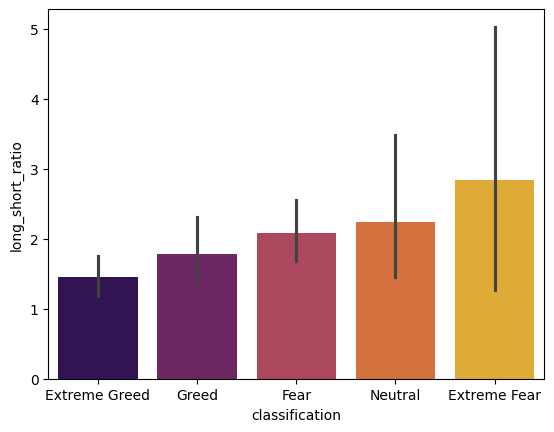

In [ ]:
df.groupby('classification')['long_short_ratio'].mean()
sns.barplot(data=df, x='classification', y='long_short_ratio',palette="inferno")

# **Actionable Output**

Github Repository Link: https://github.com/RoshanVarma706/trader-sentiment-analysis

1. The "Volatility Quality" Filter (Target: Frequent Traders)Finding: Frequent traders experience high losses during Fear/Extreme Fear, despite these periods having the highest Average PnL ($5,328.81$).
 This indicates that high-frequency "noise" trading in volatile markets erodes capital through slippage and bad entries.Actionable Rule: During Fear or Extreme Fear days, implement a "Trade Frequency Cap." * Threshold: If a trader's daily frequency exceeds their 7-day average by 2x during a Fear event, trigger a "High-Volatility Warning" or increase their margin requirements to prevent revenge trading.Goal: Force a "Quality over Quantity" approach when market emotions are high.

2. The "Greed-Trap" Exposure ReductionFinding: Greed days show the lowest Average PnL ($3,318.10$), and win rates in Greed ($30,599$) are lower than in Fear ($31,659$). This suggests that traders often enter "crowded trades" or buy the top during Greed cycles, leading to poor risk-reward ratios.Actionable Rule: During Greed and Extreme Greed classifications, automatically reduce maximum allowable leverage by 25% for all accounts.Goal: Protect traders from "exit liquidity" events and "blow-off tops" where the statistical probability of a high-profit trade is at its lowest.